# Dataset Features

This dataset provides information on a `(year, weekofyear)` timescale. Where applicable, units are indicated with a `_unit` suffix on the feature name.

## City and Date Indicators
- **city**: City abbreviations:
  - `sj` for San Juan
  - `iq` for Iquitos
- **week_start_date**: Date in `yyyy-mm-dd` format.

## NOAA's GHCN Daily Climate Data (Weather Station Measurements)
- **station_max_temp_c**: Maximum temperature (°C).
- **station_min_temp_c**: Minimum temperature (°C).
- **station_avg_temp_c**: Average temperature (°C).
- **station_precip_mm**: Total precipitation (mm).
- **station_diur_temp_rng_c**: Diurnal temperature range (°C).

## PERSIANN Satellite Precipitation Measurements
- **precipitation_amt_mm**: Total precipitation (mm) on a 0.25x0.25 degree scale.

## NOAA's NCEP Climate Forecast System Reanalysis Measurements
- **reanalysis_sat_precip_amt_mm**: Total precipitation (mm).
- **reanalysis_dew_point_temp_k**: Mean dew point temperature (K).
- **reanalysis_air_temp_k**: Mean air temperature (K).
- **reanalysis_relative_humidity_percent**: Mean relative humidity (%).
- **reanalysis_specific_humidity_g_per_kg**: Mean specific humidity (g/kg).
- **reanalysis_precip_amt_kg_per_m2**: Total precipitation (kg/m²).
- **reanalysis_max_air_temp_k**: Maximum air temperature (K).
- **reanalysis_min_air_temp_k**: Minimum air temperature (K).
- **reanalysis_avg_temp_k**: Average air temperature (K).
- **reanalysis_tdtr_k**: Diurnal temperature range (K).

## Satellite Vegetation - Normalized Difference Vegetation Index (NDVI)
(NOAA's CDR Normalized Difference Vegetation Index on a 0.5x0.5 degree scale)
- **ndvi_se**: NDVI for the pixel southeast of the city centroid.
- **ndvi_sw**: NDVI for the pixel southwest of the city centroid.
- **ndvi_ne**: NDVI for the pixel northeast of the city centroid.
- **ndvi_nw**: NDVI for the pixel northwest of the city centroid.

In [1]:
!pip install xgboost
!pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 28.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 25.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix

from lazypredict.Supervised import LazyRegressor

In [5]:
train_features = pd.read_csv('dados/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv')

train_labels = pd.read_csv('dados/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv')

test_features = pd.read_csv('dados/DengAI_Predicting_Disease_Spread_-_Test_Data_Features.csv')


In [6]:
train_features.head()

city  year  weekofyear week_start_date  ndvi_ne  ndvi_nw  ndvi_se  ndvi_sw  \
0   sj  1990          18      1990-04-30     0.12     0.10     0.20     0.18   
1   sj  1990          19      1990-05-07     0.17     0.14     0.16     0.16   
2   sj  1990          20      1990-05-14     0.03     0.17     0.16     0.17   
3   sj  1990          21      1990-05-21     0.13     0.25     0.23     0.24   
4   sj  1990          22      1990-05-28     0.20     0.26     0.25     0.25   

   precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0                 12.42                 297.57  ...   
1                 22.82                 298.21  ...   
2                 34.54                 298.78  ...   
3                 15.36                 298.99  ...   
4                  7.52                 299.52  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                                 73.37   
1                            17.94                                 77.37   
2                            26.10                                 82.05   
3                            13.90                                 80.34   
4                            12.20                                 80.46   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                                  14.01   
1                         22.82                                  15.37   
2                         34.54                                  16.85   
3                         15.36                                  16.67   
4                          7.52                                  17.21   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0               2.63               25.44                     6.90   
1               2.37               26.71                     6.37   
2               2.30               26.71                     6.49   
3               2.43               27.47                     6.77   
4               3.01               28.94                     9.37   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0               29.40               20.00              16.00  
1               31.70               22.20               8.60  
2               32.20               22.80              41.40  
3               33.30               23.30               4.00  
4               35.00               23.90               5.80  

[5 rows x 24 columns]

In [7]:
train_labels.head()

city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4
3   sj  1990          21            3
4   sj  1990          22            6

In [8]:
train_features['city'].unique()

array(['sj', 'iq'], dtype=object)

# Análise exploratória dos dados

In [9]:
all_data = pd.merge(train_features, train_labels, on=['city', 'year', 'weekofyear'])

missing_values = all_data.isnull().sum()

missing_values[missing_values > 0]

ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64

In [10]:
# testando preencher os dados com a media
data_imputed = all_data.fillna(train_features.mean(numeric_only=True))

numerical_cols = data_imputed.select_dtypes(include=['float64', 'int64']).columns
numerical_data = data_imputed[numerical_cols]

In [11]:
categorical_cols = all_data.select_dtypes(include=['object']).columns



In [12]:
all_data.head()

city  year  weekofyear week_start_date  ndvi_ne  ndvi_nw  ndvi_se  ndvi_sw  \
0   sj  1990          18      1990-04-30     0.12     0.10     0.20     0.18   
1   sj  1990          19      1990-05-07     0.17     0.14     0.16     0.16   
2   sj  1990          20      1990-05-14     0.03     0.17     0.16     0.17   
3   sj  1990          21      1990-05-21     0.13     0.25     0.23     0.24   
4   sj  1990          22      1990-05-28     0.20     0.26     0.25     0.25   

   precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0                 12.42                 297.57  ...   
1                 22.82                 298.21  ...   
2                 34.54                 298.78  ...   
3                 15.36                 298.99  ...   
4                  7.52                 299.52  ...   

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                                 73.37                         12.42   
1                                 77.37                         22.82   
2                                 82.05                         34.54   
3                                 80.34                         15.36   
4                                 80.46                          7.52   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
0                                  14.01               2.63   
1                                  15.37               2.37   
2                                  16.85               2.30   
3                                  16.67               2.43   
4                                  17.21               3.01   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0               25.44                     6.90               29.40   
1               26.71                     6.37               31.70   
2               26.71                     6.49               32.20   
3               27.47                     6.77               33.30   
4               28.94                     9.37               35.00   

   station_min_temp_c  station_precip_mm  total_cases  
0               20.00              16.00            4  
1               22.20               8.60            5  
2               22.80              41.40            4  
3               23.30               4.00            3  
4               23.90               5.80            6  

[5 rows x 25 columns]

Distribuição da variável 'city':
city
sj    936
iq    520
Name: count, dtype: int64


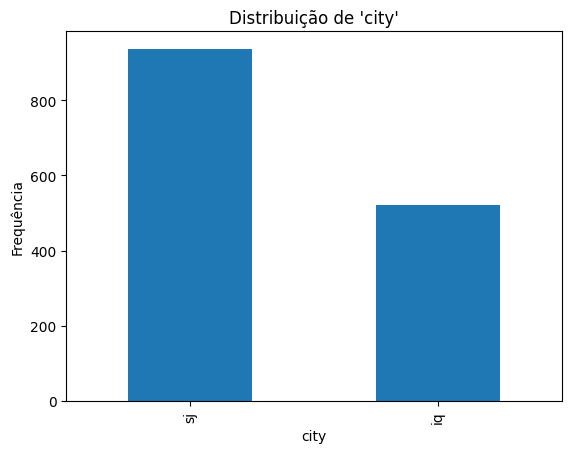

In [13]:
for col in categorical_cols[0:1]:
  print(f"Distribuição da variável '{col}':")
  print(all_data[col].value_counts())

  all_data[col].value_counts().plot.bar(title=f"Distribuição de '{col}'")
  plt.xlabel(col)
  plt.ylabel("Frequência")
  plt.show()

In [14]:
all_data.drop('week_start_date', axis=1, inplace=True)

In [15]:
pd.isnull(all_data).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_t

Podemos ver que praticamente todas as variáveis possuem dados faltando. Como podemos ver no gráfico abaixo.

Text(0.5, 0, 'Time')

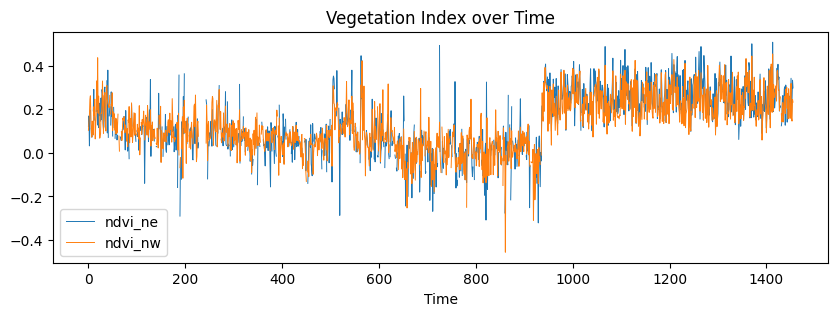

In [16]:
plt.figure(figsize=(10,3))
all_data['ndvi_ne'].plot(lw=0.7)
all_data['ndvi_nw'].plot(lw=0.7)
plt.legend()

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

Os dados faltando aparecem como "falhas" ou "gaps" no sinal.

## Fill NaN

Maneiras de solucionar isso são: Preencher os dados faltando com algum valor, pode ser média, ultimo valor válido. Ou ainda remover todos os dados. 

In [17]:
# Preenchendo os valores faltantes com a média dos valores anteriores
all_data.fillna(method='ffill', inplace=True)
train_features.fillna(method='ffill', inplace=True)
train_labels.fillna(method='ffill', inplace=True)

In [18]:
pd.isnull(train_features).any()

city                                     False
year                                     False
weekofyear                               False
week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_t

In [19]:
test_features.fillna(method='ffill',inplace=True)

In [20]:
pd.isnull(test_features).any()

city                                     False
year                                     False
weekofyear                               False
week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_t

Text(0, 0.5, 'Frequência')

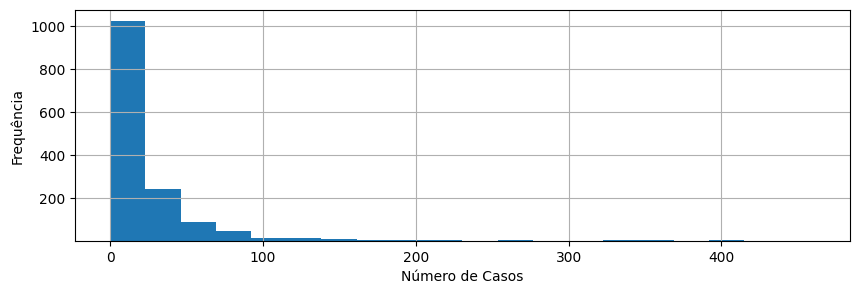

In [21]:
fig, ax = plt.subplots(figsize=(10,3))
all_data['total_cases'].hist(bins=20, bottom=0.1)
ax.set_xlabel('Número de Casos')
ax.set_ylabel('Frequência')

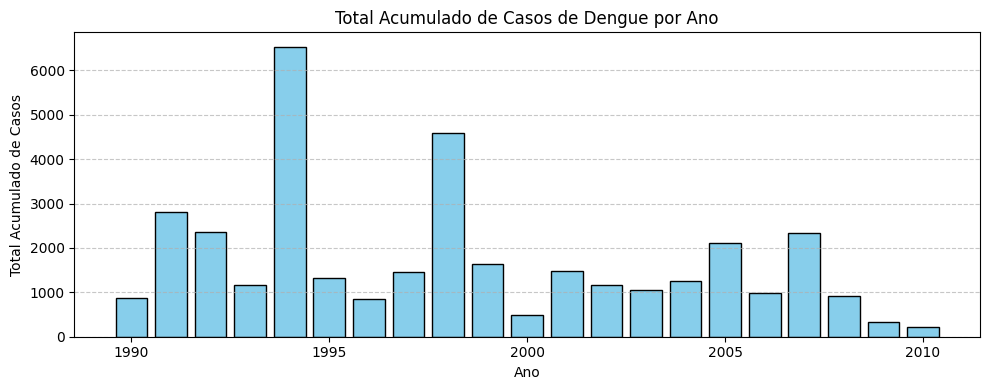

In [22]:
cases_by_year = all_data.groupby('year')['total_cases'].sum().reset_index()

# Plotando o acumulado de casos por ano
plt.figure(figsize=(10, 4))
plt.bar(cases_by_year['year'], cases_by_year['total_cases'], color='skyblue', edgecolor='black')
plt.xlabel('Ano')
plt.ylabel('Total Acumulado de Casos')
plt.title('Total Acumulado de Casos de Dengue por Ano')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

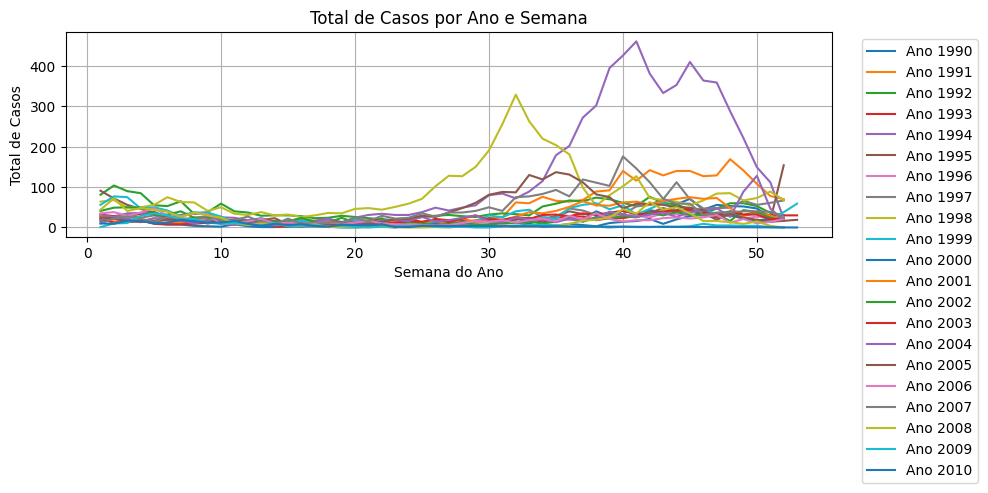

In [23]:
cases_by_year_week = train_labels.groupby(['year', 'weekofyear'])['total_cases'].sum().reset_index()

# Plotando os casos por ano e semana
plt.figure(figsize=(10, 4))
for year in cases_by_year_week['year'].unique():
    yearly_data = cases_by_year_week[cases_by_year_week['year'] == year]
    plt.plot(yearly_data['weekofyear'], yearly_data['total_cases'], label=f'Ano {year}')

plt.xlabel('Semana do Ano')
plt.ylabel('Total de Casos')
plt.title('Total de Casos por Ano e Semana')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid()
plt.tight_layout()
plt.show()

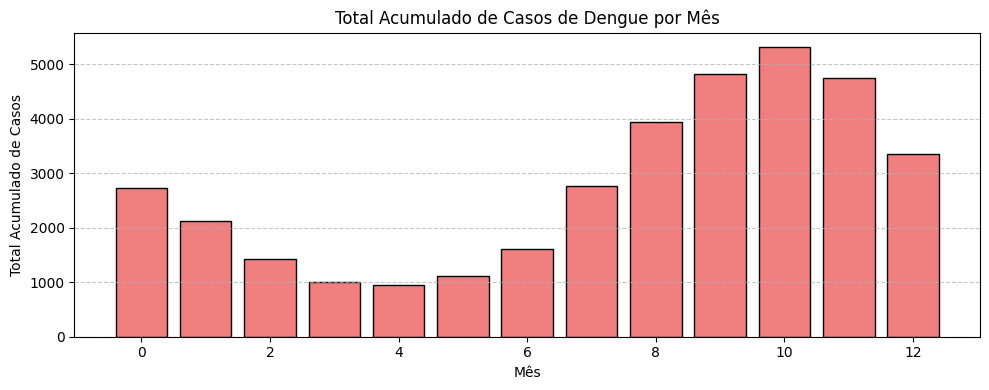

In [24]:
# Criando a coluna 'month' baseada nos intervalos de semanas
train_labels['month'] = pd.cut(
    train_labels['weekofyear'],
    bins=[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 53]
)


# Calculando o total acumulado de casos por mês
cases_by_month = train_labels.groupby('month')['total_cases'].sum().reset_index()

# Plotando o acumulado de casos por mês
plt.figure(figsize=(10, 4))
plt.bar(cases_by_month.index, cases_by_month['total_cases'], color='lightcoral', edgecolor='black')
plt.xlabel('Mês')
plt.ylabel('Total Acumulado de Casos')
plt.title('Total Acumulado de Casos de Dengue por Mês')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As figuras mostram padrões importantes nos casos de dengue:
1.	O primeiro gráfico mostra o total acumulado de casos por ano, evidenciando picos em anos específicos como 1995 e 2005, possivelmente associados a condições ambientais ou eventos extraordinários.
2.	O segundo gráfico ilustra a evolução semanal dos casos por ano, destacando um aumento significativo em determinados anos, indicando possíveis surtos sazonais.
3.	O terceiro gráfico apresenta a distribuição acumulada de casos por mês, com um aumento claro nos meses de setembro a novembro, sugerindo sazonalidade no aumento de casos.

In [25]:
# sns.pairplot(numerical_data)

<Axes: >

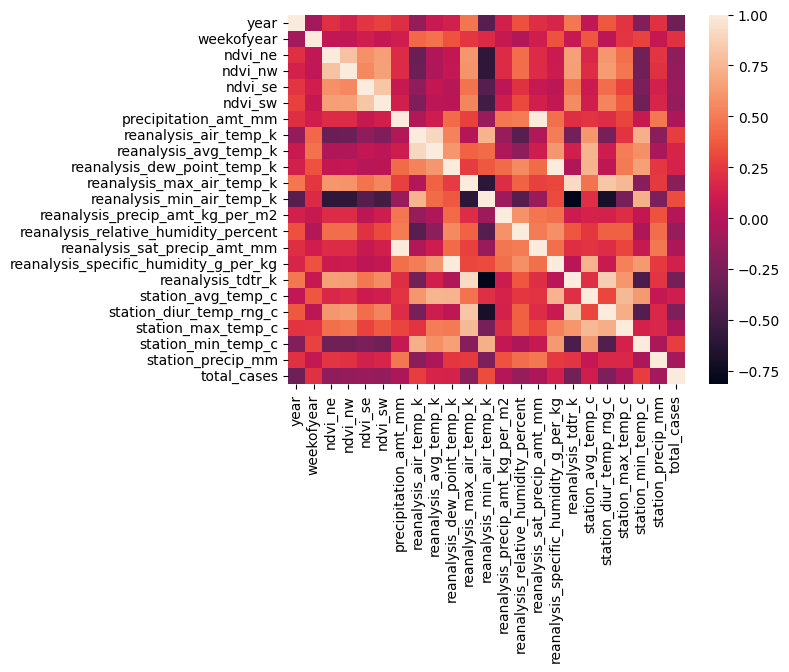

In [26]:
corr = numerical_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Correlação geral entre as features do dataset. Nota-se algumas correlações altas entre alguns parâmetros. Tais como: precipitação e umidade, vegetação e temperatura mais baixa, entre outros.

In [27]:
sj_correlations = all_data[all_data['city'] == 'sj'][all_data.columns[3:]].corr()
iq_correlations = all_data[all_data['city'] == 'iq'][all_data.columns[3:]].corr()


Text(0.5, 1.0, 'San Juan Variable Correlations')

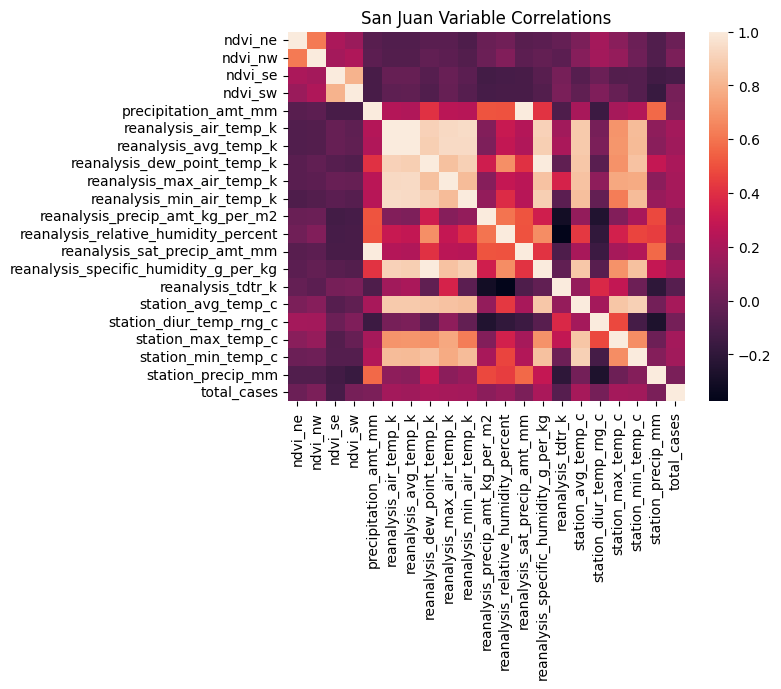

In [28]:
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

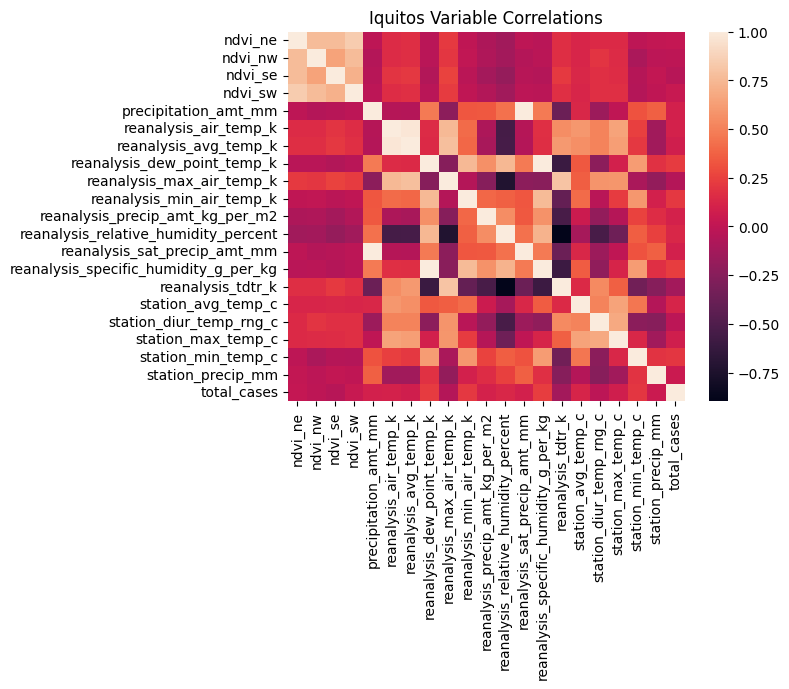

In [29]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

Nota-se que algumas correlações se manté, se comparado com o dataset geral, mas entre as duas cidades, as correlações entre as variáveis muda bastante. Um dos fatores que pode influenciar é a vegetação predominante do local.

# Análise de segmentação

In [30]:
numerical_data.head()
# numerical_data.drop(['year', 'weekofyear'], axis=1, inplace=True)

year  weekofyear  ndvi_ne  ndvi_nw  ndvi_se  ndvi_sw  precipitation_amt_mm  \
0  1990          18     0.12     0.10     0.20     0.18                 12.42   
1  1990          19     0.17     0.14     0.16     0.16                 22.82   
2  1990          20     0.03     0.17     0.16     0.17                 34.54   
3  1990          21     0.13     0.25     0.23     0.24                 15.36   
4  1990          22     0.20     0.26     0.25     0.25                  7.52   

   reanalysis_air_temp_k  reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
0                 297.57                 297.74                       292.41   
1                 298.21                 298.44                       293.95   
2                 298.78                 298.88                       295.43   
3                 298.99                 299.23                       295.31   
4                 299.52                 299.66                       295.82   

   ...  reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0  ...                                 73.37                         12.42   
1  ...                                 77.37                         22.82   
2  ...                                 82.05                         34.54   
3  ...                                 80.34                         15.36   
4  ...                                 80.46                          7.52   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
0                                  14.01               2.63   
1                                  15.37               2.37   
2                                  16.85               2.30   
3                                  16.67               2.43   
4                                  17.21               3.01   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0               25.44                     6.90               29.40   
1               26.71                     6.37               31.70   
2               26.71                     6.49               32.20   
3               27.47                     6.77               33.30   
4               28.94                     9.37               35.00   

   station_min_temp_c  station_precip_mm  total_cases  
0               20.00              16.00            4  
1               22.20               8.60            5  
2               22.80              41.40            4  
3               23.30               4.00            3  
4               23.90               5.80            6  

[5 rows x 23 columns]

## Teste separando o dataset em risco alto e baixo.

- Número de casos acima da mediana ou percentil 75 pode ser considerado como alto risco, enquanto valores abaixo disso são baixo risco.
- 1 para alto risco e 0 para baixo risco

In [31]:
risk_threshold = train_labels['total_cases'].quantile(0.75)

# Criando a nova variável de risco
train_labels['risk_level'] = (train_labels['total_cases'] > risk_threshold).astype(int)

# Exibindo a distribuição das classes (0: baixo risco, 1: alto risco)
class_distribution = train_labels['risk_level'].value_counts()

In [32]:
class_distribution

risk_level
0    1102
1     354
Name: count, dtype: int64

<Axes: xlabel='station_avg_temp_c', ylabel='station_precip_mm'>

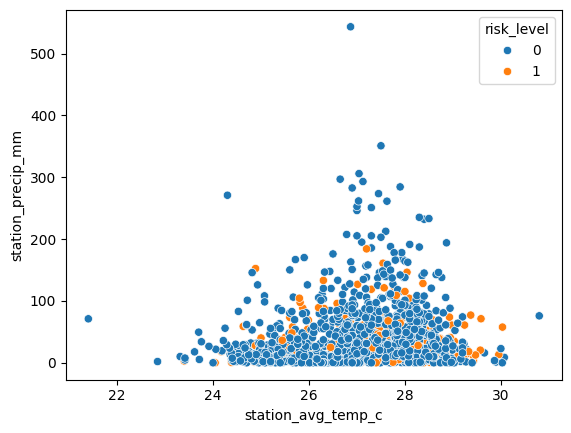

In [33]:
data = pd.merge(train_features, train_labels[['city', 'year', 'weekofyear', 'risk_level']], on=['city', 'year', 'weekofyear'])
sns.scatterplot(data = data,
                x = "station_avg_temp_c",
                y = "station_precip_mm",
                hue = "risk_level")

<Axes: xlabel='ndvi_nw', ylabel='station_avg_temp_c'>

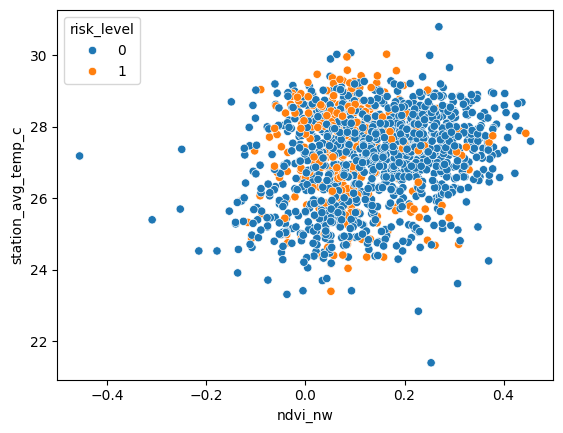

In [34]:
sns.scatterplot(data = data,
                x = "ndvi_nw",
                y = "station_avg_temp_c",
                hue = "risk_level")

Percebe-se que nao conseguimos separa as condições de temperatura, precipitação... de acordo com a incidência de casos de dengue. Logo a clusterização nesses parâmetros se torna mais complicada para esse dataset. 

Predisposição para casos de dengue é a partir de ~ 25 graus

## Separando algumas features por cidades

<Axes: xlabel='ndvi_nw', ylabel='station_avg_temp_c'>

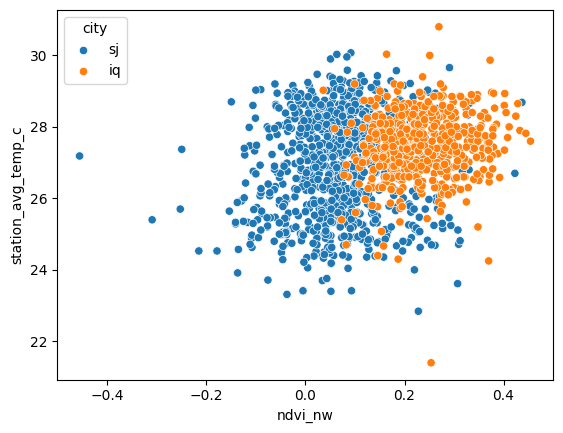

In [35]:
sns.scatterplot(data = all_data,
                x = "ndvi_nw",
                y = "station_avg_temp_c",
                hue = "city")

<Axes: xlabel='station_avg_temp_c', ylabel='station_precip_mm'>

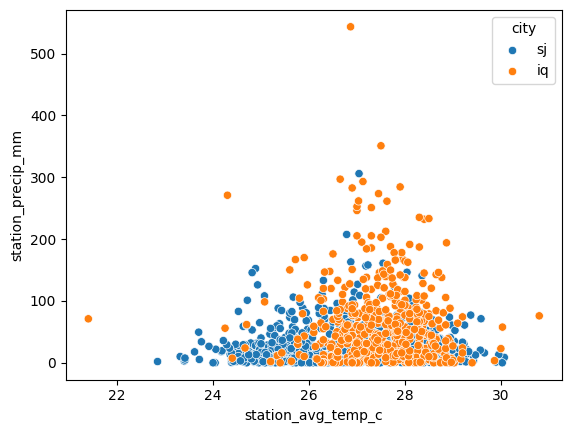

In [36]:
sns.scatterplot(data = all_data,
                x = "station_avg_temp_c",
                y = "station_precip_mm",
                hue = "city")

### Testando métodos de clusterização

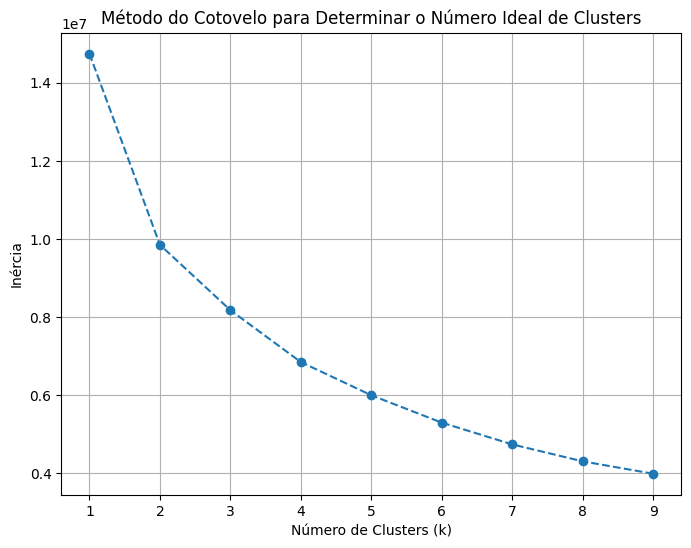

In [37]:
inertia_reduced = []
k_values_reduced = range(1, 10)  # Testando de 1 a 6 clusters

for k in k_values_reduced:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numerical_data)
    inertia_reduced.append(kmeans.inertia_)

# Plotando o método do cotovelo com clusters reduzidos
plt.figure(figsize=(8, 6))
plt.plot(k_values_reduced, inertia_reduced, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
plt.grid()
plt.show()

O gráfico tem uma queda abrupta logo no início, sugerindo que temos 2 clusters principais. Isso até faz sentido, pois temos duas cidades em nosso dataset

### Kmeans

In [38]:
# Aplicando K-Means para as variáveis selecionadas (temperatura)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit(numerical_data)

In [39]:
kmeans.predict(numerical_data)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [40]:
labels_clusters = kmeans.labels_

In [41]:
labels_series = pd.Series(labels_clusters, name = "label")

In [42]:
df_result = pd.concat([numerical_data, labels_series], axis = 1)

<Axes: xlabel='station_avg_temp_c', ylabel='station_precip_mm'>

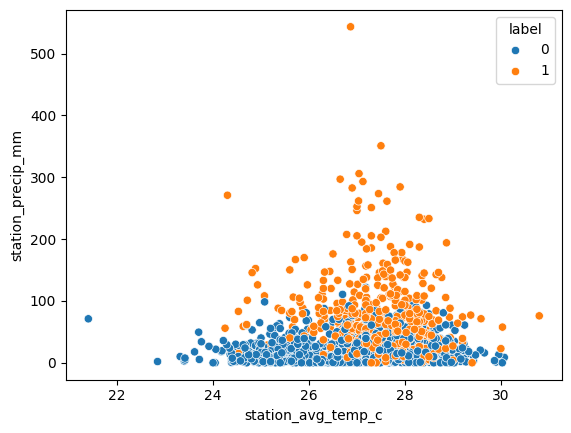

In [43]:
sns.scatterplot(data = df_result,
                x = "station_avg_temp_c",
                y = "station_precip_mm",
                hue = "label")

O teste com KMeans mostrou dois clusters principais quando visualizamos os dados de precipitaçåo e temperatura média. O gráfico tem uma distribuição similar ao da separação por cidades.

<Axes: xlabel='ndvi_nw', ylabel='station_avg_temp_c'>

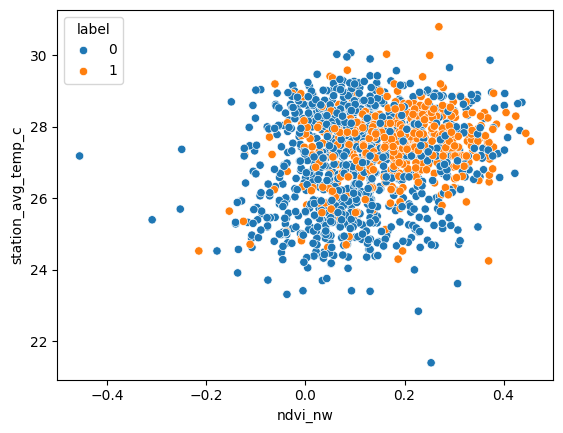

In [44]:
sns.scatterplot(data = df_result,
                x = "ndvi_nw",
                y = "station_avg_temp_c",
                hue = "label")

A clusterizaçåo por te temperatura e vegetação apresenta uma concentração maior de pontos em torno de 0.2 para ndvi_nw, o que se aproxima da concentrção de dados de Iquitos.

## Teste DBSCAN

In [45]:
dbscan = DBSCAN()
dbscan.fit(numerical_data) 

DBSCAN()

In [46]:
def plot_dbscan(df, eps, min_pts, x1, x2):
     # Instanciamento e fit do modelo
    dbscan = DBSCAN(eps = eps, min_samples = min_pts)
    dbscan.fit(df)

    # ========================================
    # estruturação dos resultados
    labels_clusters = dbscan.labels_
    labels_series = pd.Series(labels_clusters, name="label")

    df_result = pd.concat([df, labels_series], axis=1)
    n_clusters = pd.Series(labels_clusters).nunique()

    # ========================================
    print(f"DBSCAN com eps={eps} e minPts={min_pts}\nNúmero de clusters: {n_clusters}")
    sns.scatterplot(data=df_result, x=x1, y=x2, hue="label", palette="tab10")
    plt.show()

    print("Quantidade de pontos em cada clusters:")
    print(pd.Series(labels_clusters).value_counts())

    return df_result, n_clusters

DBSCAN com eps=22 e minPts=10
Número de clusters: 3


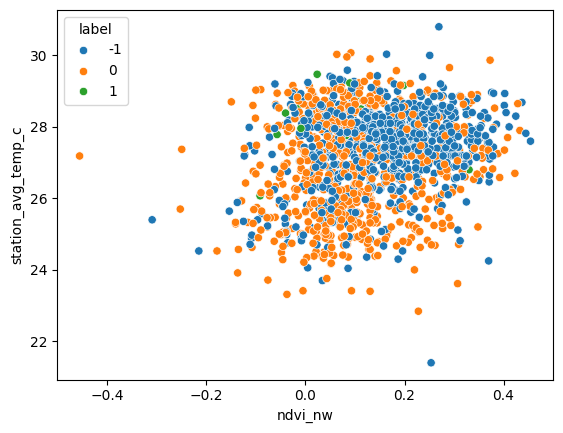

Quantidade de pontos em cada clusters:
-1    740
 0    698
 1     18
Name: count, dtype: int64


In [47]:
df_result, n_clusters = plot_dbscan(numerical_data,
                                   eps = 22,
                                   x1 = "ndvi_nw",
                                   x2 = "station_avg_temp_c",
                                   min_pts = 10)

In [48]:
dimensionalidade = numerical_data.shape[1]  # Número de colunas (dimensões)
MinPts = 2 * dimensionalidade
print(f"MinPts definido como: {MinPts}")

MinPts definido como: 46


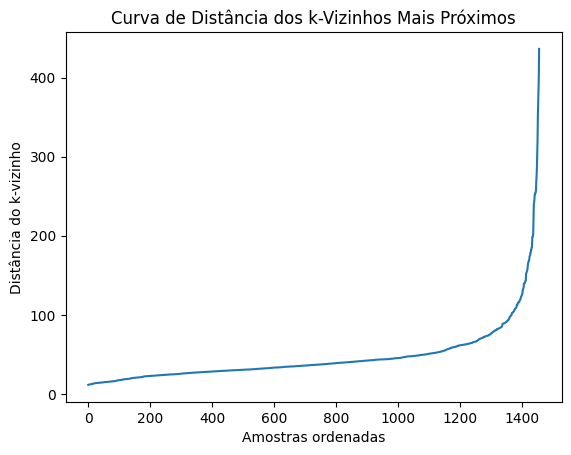

In [49]:
nbrs = NearestNeighbors(n_neighbors=MinPts).fit(numerical_data)
distances, _ = nbrs.kneighbors(numerical_data)

# Ordenando as distâncias para encontrar o ponto de cotovelo
distances = np.sort(distances[:, MinPts - 1])  # Distância do k-vizinho mais distante
plt.plot(distances)
plt.title("Curva de Distância dos k-Vizinhos Mais Próximos")
plt.xlabel("Amostras ordenadas")
plt.ylabel("Distância do k-vizinho")
plt.show()

In [50]:
# Testar diferentes combinações
eps_values = np.linspace(0.1, 50, 100)  # Intervalo de Eps
minpts_values = [2, 4, 6, 8]  # Diferentes valores para MinPts

melhor_silhouette = -1
melhor_configuracao = None

for eps in eps_values:
    for minpts in minpts_values:
        dbscan = DBSCAN(eps=eps, min_samples=minpts).fit(numerical_data)
        labels = dbscan.labels_

        # Ignorar clusters com ruído total
        if len(set(labels)) > 1:
            score = silhouette_score(numerical_data, labels)
            print(f"Eps: {eps}, MinPts: {minpts}, Silhouette Score: {score:.3f}")

            if score > melhor_silhouette:
                melhor_silhouette = score
                melhor_configuracao = (eps, minpts)

print(f"Melhor configuração: Eps = {melhor_configuracao[0]}, MinPts = {melhor_configuracao[1]}")

Eps: 1.1080808080808082, MinPts: 2, Silhouette Score: -0.287
Eps: 1.6121212121212123, MinPts: 2, Silhouette Score: -0.287
Eps: 2.1161616161616164, MinPts: 2, Silhouette Score: -0.287
Eps: 2.6202020202020204, MinPts: 2, Silhouette Score: -0.287
Eps: 3.1242424242424245, MinPts: 2, Silhouette Score: -0.287
Eps: 3.6282828282828286, MinPts: 2, Silhouette Score: -0.438
Eps: 4.132323232323232, MinPts: 2, Silhouette Score: -0.449
Eps: 4.636363636363637, MinPts: 2, Silhouette Score: -0.455
Eps: 5.14040404040404, MinPts: 2, Silhouette Score: -0.448
Eps: 5.14040404040404, MinPts: 4, Silhouette Score: -0.164
Eps: 5.644444444444444, MinPts: 2, Silhouette Score: -0.441
Eps: 5.644444444444444, MinPts: 4, Silhouette Score: -0.174
Eps: 6.148484848484848, MinPts: 2, Silhouette Score: -0.461
Eps: 6.148484848484848, MinPts: 4, Silhouette Score: -0.169
Eps: 6.148484848484848, MinPts: 6, Silhouette Score: -0.161
Eps: 6.148484848484848, MinPts: 8, Silhouette Score: -0.162
Eps: 6.652525252525253, MinPts: 2, S

In [51]:
casos_sj = all_data[all_data['city'] == 'sj']['total_cases'].mean()
casos_iq = all_data[all_data['city'] == 'iq']['total_cases'].mean()

print(f"Media de casos em San Juan: {casos_sj}")
print(f"Media de casos em Iquitos: {casos_iq}")

Media de casos em San Juan: 34.18055555555556
Media de casos em Iquitos: 7.565384615384615


# Análise Preditiva

### Separando os dados de treino e teste

In [52]:
X = train_features.select_dtypes(include=['float64', 'int64'])
y = train_labels['total_cases']

In [53]:
# Dividindo os dados de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificando as dimensões dos dados
print(X_train.shape, X_val.shape, test_features.shape)

(1164, 22) (292, 22) (416, 24)


In [54]:
# Treinando modelos Ridge, Lasso e XGBoost e avaliando desempenho

# Instanciando os modelos
ridge_model = Ridge(alpha=1.0, random_state=42)
lasso_model = Lasso(alpha=0.1, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

In [55]:
# Treinando os modelos
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [56]:
# Fazendo previsões no conjunto de validação
ridge_preds = ridge_model.predict(X_val)
lasso_preds = lasso_model.predict(X_val)
xgb_preds = xgb_model.predict(X_val)

In [57]:
ridge_rmse = mean_squared_error(y_val, ridge_preds, squared=False)
lasso_rmse = mean_squared_error(y_val, lasso_preds, squared=False)
xgb_rmse = mean_squared_error(y_val, xgb_preds, squared=False)

ridge_r2 = r2_score(y_val, ridge_preds)
lasso_r2 = r2_score(y_val, lasso_preds)
xgb_r2 = r2_score(y_val, xgb_preds)



In [58]:
# Exibindo os resultados
results = pd.DataFrame({
    "Modelo": ["Ridge", "Lasso", "XGBoost"],
    "RMSE": [ridge_rmse, lasso_rmse, xgb_rmse],
    "R2": [ridge_r2, lasso_r2, xgb_r2]
})

# Exibindo a tabela
print(results)

    Modelo  RMSE   R2
0    Ridge 51.29 0.18
1    Lasso 51.67 0.17
2  XGBoost 28.67 0.74


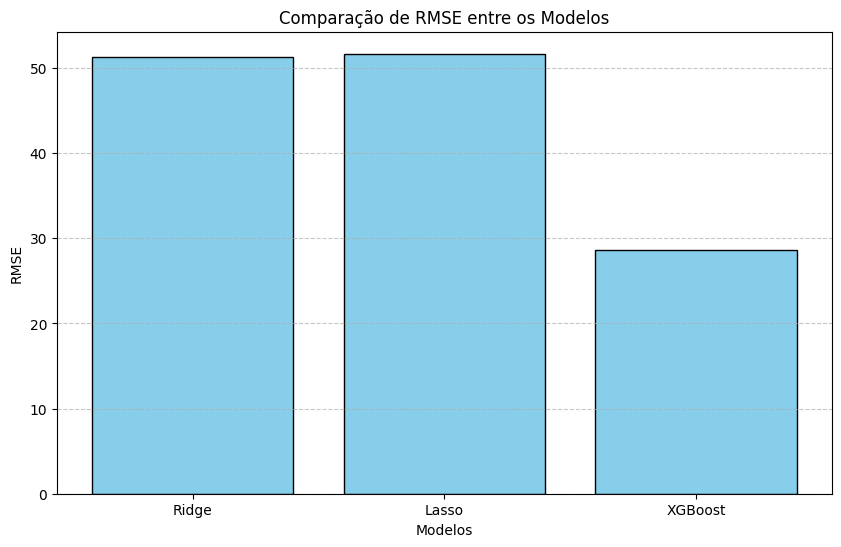

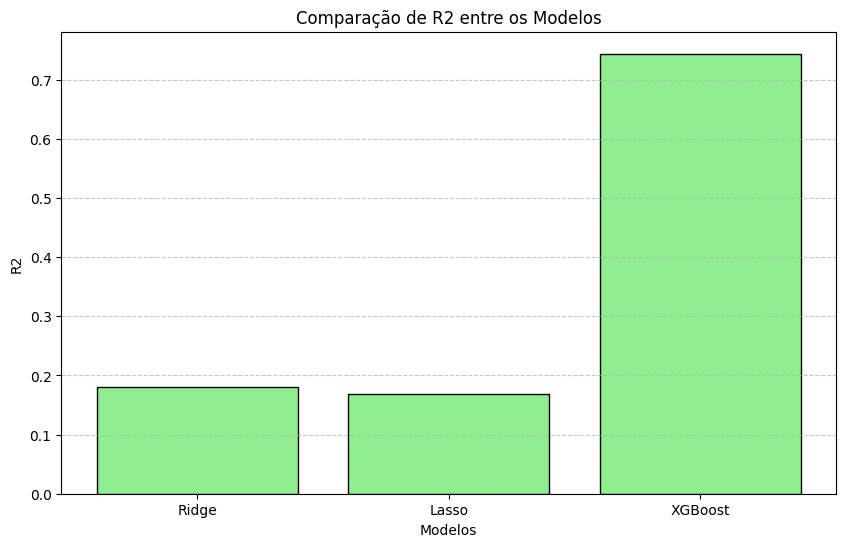

In [59]:
models = ["Ridge", "Lasso", "XGBoost"]
rmse_values = [ridge_rmse, lasso_rmse, xgb_rmse]
r2_values = [ridge_r2, lasso_r2, xgb_r2]

# Gráfico de RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='skyblue', edgecolor='black')
plt.title('Comparação de RMSE entre os Modelos')
plt.ylabel('RMSE')
plt.xlabel('Modelos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de R2
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='lightgreen', edgecolor='black')
plt.title('Comparação de R2 entre os Modelos')
plt.ylabel('R2')
plt.xlabel('Modelos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. RMSE (Root Mean Squared Error):
   
    - Mede a magnitude média do erro das previsões.
    - Valores mais baixos indicam que o modelo está mais próximo das observações reais.
2. $R^2$  (Coeficiente de Determinação):
   - Mede a proporção da variância da variável alvo que o modelo consegue explicar.
   - Varia entre 0 e 1 (ou valores negativos se o modelo for muito ruim).
   - Valores mais próximos de 1 indicam que o modelo explica bem as variações nos dados.

## Criando um XGbosst  para cada cidade

In [60]:
train_features

city  year  weekofyear week_start_date  ndvi_ne  ndvi_nw  ndvi_se  \
0      sj  1990          18      1990-04-30     0.12     0.10     0.20   
1      sj  1990          19      1990-05-07     0.17     0.14     0.16   
2      sj  1990          20      1990-05-14     0.03     0.17     0.16   
3      sj  1990          21      1990-05-21     0.13     0.25     0.23   
4      sj  1990          22      1990-05-28     0.20     0.26     0.25   
...   ...   ...         ...             ...      ...      ...      ...   
1451   iq  2010          21      2010-05-28     0.34     0.32     0.26   
1452   iq  2010          22      2010-06-04     0.16     0.16     0.14   
1453   iq  2010          23      2010-06-11     0.25     0.15     0.25   
1454   iq  2010          24      2010-06-18     0.33     0.25     0.28   
1455   iq  2010          25      2010-06-25     0.30     0.23     0.27   

      ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0        0.18                 12.42                 297.57  ...   
1        0.16                 22.82                 298.21  ...   
2        0.17                 34.54                 298.78  ...   
3        0.24                 15.36                 298.99  ...   
4        0.25                  7.52                 299.52  ...   
...       ...                   ...                    ...  ...   
1451     0.29                 55.30                 299.33  ...   
1452     0.23                 86.47                 298.33  ...   
1453     0.23                 58.94                 296.60  ...   
1454     0.33                 59.67                 296.35  ...   
1455     0.32                 63.22                 298.10  ...   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                               32.00                                 73.37   
1                               17.94                                 77.37   
2                               26.10                                 82.05   
3                               13.90                                 80.34   
4                               12.20                                 80.46   
...                               ...                                   ...   
1451                            45.00                                 88.77   
1452                           207.10                                 91.60   
1453                            50.60                                 94.28   
1454                            62.33                                 94.66   
1455                            36.90                                 89.08   

      reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                            12.42                                  14.01   
1                            22.82                                  15.37   
2                            34.54                                  16.85   
3                            15.36                                  16.67   
4                             7.52                                  17.21   
...                            ...                                    ...   
1451                         55.30                                  18.49   
1452                         86.47                                  18.07   
1453                         58.94                                  17.01   
1454                         59.67                                  16.82   
1455                         63.22                                  17.36   

      reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0                  2.63               25.44                     6.90   
1                  2.37               26.71                     6.37   
2                  2.30               26.71                     6.49   
3                  2.43               27.47                     6.77   
4                  3.01               28.94                     9.37   
...  

In [62]:
sj_train_features = train_features[train_features['city'] == 'sj']
sj_train_labels = train_labels[train_labels['city'] == 'sj']

iq_train_features = train_features[train_features['city'] == 'iq']
iq_train_labels = train_labels[train_labels['city'] == 'iq']

sj_train_features.drop('city', axis=1, inplace=True)
iq_train_features.drop('city', axis=1, inplace=True)

sj_test_features = test_features[test_features['city'] == 'sj']
iq_test_features = test_features[test_features['city'] == 'iq']

sj_test_features.drop('city', axis=1, inplace=True)
iq_test_features.drop('city', axis=1, inplace=True)



# San Juan

In [63]:
X_sj = sj_train_features.select_dtypes(include=['float64', 'int64'])
y_sj = sj_train_labels['total_cases']

X_test_sj = sj_test_features.select_dtypes(include=['float64', 'int64'])

In [64]:
X_train_sj, X_val_sj, y_train_sj, y_val_sj = train_test_split(X_sj, y_sj, test_size=0.2, random_state=42)

# Treinando modelos Ridge, Lasso e XGBoost e avaliando desempenho

# Instanciando o modelo
xgb_model_sj = XGBRegressor(n_estimators=100, random_state=42)

# Treinando o modelo
xgb_model_sj.fit(X_train_sj, y_train_sj)

xgb_preds_sj = xgb_model_sj.predict(X_val_sj)



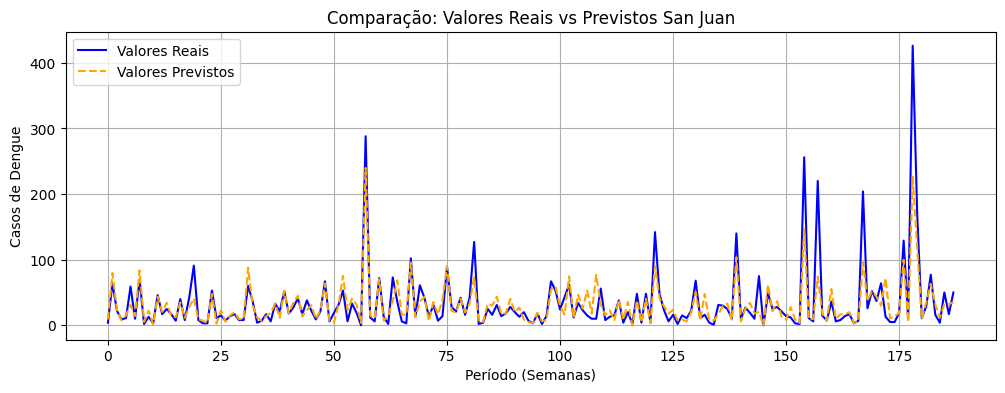

In [65]:
plt.figure(figsize=(12, 4))
plt.plot(y_val_sj.values, label="Valores Reais", color="blue")
plt.plot(xgb_preds_sj, label="Valores Previstos", color="orange", linestyle="--")
plt.title("Comparação: Valores Reais vs Previstos San Juan")
plt.xlabel("Período (Semanas)")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
# Previsão no conjunto de teste
y_pred_sj = xgb_model.predict(X_test_sj).astype(int)


# Iquitos

In [67]:
X_iq = iq_train_features.select_dtypes(include=['float64', 'int64'])
y_iq = iq_train_labels['total_cases']

X_test_iq = iq_test_features.select_dtypes(include=['float64', 'int64'])

In [68]:
X_train_iq, X_val_iq, y_train_iq, y_val_iq = train_test_split(X_iq, y_iq, test_size=0.2, random_state=42)

# Treinando modelos Ridge, Lasso e XGBoost e avaliando desempenho

# Instanciando o modelo
xgb_model_iq = XGBRegressor(n_estimators=100, random_state=42)

# Treinando o modelo
xgb_model_iq.fit(X_train_iq, y_train_iq)

xgb_preds_iq = xgb_model_iq.predict(X_val_iq)

In [69]:
y_pred_iq = xgb_model_iq.predict(X_test_iq).astype(int)

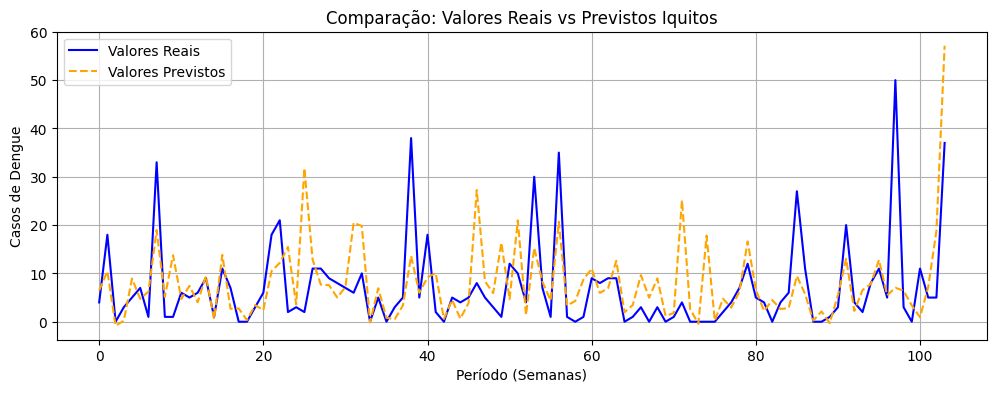

In [70]:
plt.figure(figsize=(12, 4))
plt.plot(y_val_iq.values, label="Valores Reais", color="blue")
plt.plot(xgb_preds_iq, label="Valores Previstos", color="orange", linestyle="--")
plt.title("Comparação: Valores Reais vs Previstos Iquitos")
plt.xlabel("Período (Semanas)")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.grid(True)
plt.show()

# Resultados das Previsões de Casos de Dengue

## Iquitos
- **Observações**:
  - A previsão (linha laranja pontilhada) acompanha razoavelmente bem os padrões da série real (linha azul), capturando a sazonalidade e os picos.
  - Existem discrepâncias em alguns momentos, especialmente em picos mais altos, onde o modelo parece subestimar ou superestimar os valores.

## San Juan
- **Observações**:
  - A previsão acompanha os padrões da série real, com uma boa correspondência nos períodos de baixa e moderada incidência de casos.
  - Nos picos extremos, como nos períodos de maior incidência de casos, as previsões apresentam desvios maiores, mas ainda capturam a tendência geral.

## Avaliação Geral
- **Desempenho Geral**:
  - O modelo parece capturar a sazonalidade e os padrões gerais das séries temporais em ambas as cidades.
- **Pontos Fracos**:
  - Os picos de casos mais altos (valores extremos) são mais difíceis de prever com precisão.
  - Isso pode indicar que o modelo precisa de mais dados ou variáveis explicativas para melhorar nessas condições.
- **Sugestões de Melhorias**:
  - **Feature Engineering**: Adicionar variáveis que capturem melhor os eventos extremos, como índices climáticos ou indicadores de surtos.
  - **Ajustes do Modelo**: Experimentar modelos mais robustos para séries temporais (e.g., Prophet ou ARIMA) ou ajustar hiperparâmetros do XGBoost.

### Teste com Lazy Predict

In [72]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)

print(models)

 26%|██▌       | 11/42 [00:01<00:05,  5.87it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|██████████| 42/42 [00:06<00:00,  6.11it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4485
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 22
[LightGBM] [Info] Start training from score 23.116838
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
XGBRegressor                                 0.72       0.74 28.67        0.46
ExtraTreesRegressor                          0.69       0.71 30.33        0.82
RandomForestRegressor                        0.67       0.69 31.37        1.61
HistGradientBoostingRegressor                0.67       0.69 31.46        0.23
LGBMRegressor                                0.66       0.69 31.66        0.17
GradientBoostingRegressor                    0.66       0.69 31.78        0.76
BaggingRegressor          

In [ ]:

# submission = pd.read_csv("dados/DengAI_Predicting_Disease_Spread_-_Submission_Format.csv",
#                          index_col=[0, 1, 2])

# submission.total_cases = np.concatenate([y_pred_sj, y_pred_iq])
# submission

In [ ]:
# submission.to_csv("dados/previsoes.csv")

In [66]:


# data = pd.merge(train_features, train_labels[['city', 'year', 'weekofyear', 'risk_level']], on=['city', 'year', 'weekofyear'])

# # Selecionando apenas variáveis numéricas e o rótulo
# X = data.select_dtypes(include=['float64', 'int64']).drop(columns=['risk_level'])
# y = data['risk_level']

# # Dividindo os dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Reaplicando o modelo Random Forest
# rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_model.fit(X_train, y_train)

# # Fazendo previsões
# y_pred = rf_model.predict(X_test)

# # Avaliando o modelo
# classification_rep = classification_report(y_test, y_pred, target_names=["Baixo Risco", "Alto Risco"])
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Exibindo diretamente os resultados para evitar erros


In [67]:
# print(classification_rep)

In [68]:
# sns.heatmap(conf_matrix)